In [1]:
from bs4 import BeautifulSoup
from collections import Counter, defaultdict
import json
import os
import requests
import seaborn as sns
import shutil
from tqdm import tqdm
import pandas as pd

from PIL import Image

import torch

from torchvision import transforms
convert_tensor = transforms.ToTensor()

headers = {"User-Agent": "My User Agent"}

In [8]:
url = input()

In [18]:
response = requests.get(url, stream=True, headers=headers)
with open('example.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

In [3]:
with open("data/titlepart2href.json", encoding="utf-8") as f:
    titlepart2href = json.load(f)

In [4]:
hrefs = Counter([href for v in titlepart2href.values() for href in v])

In [5]:
hrefs.most_common(3)

[('/53101-missing', 2),
 ('/19510-romantic-doctor-teacher-kim', 2),
 ('/38301-romantic-doctor-teacher-kim-2', 2)]

In [6]:
Counter([href[0] for href in hrefs])

Counter({'/': 19461, 'h': 15})

In [7]:
optional_prefix = "https://mydramalist.com"
len([href for href in hrefs if href.startswith(optional_prefix)])

15

In [8]:
# href2dramapage = {}
with open("data/href2dramapage.json", encoding="utf-8") as f:
    href2dramapage = json.load(f)

for href in tqdm(hrefs):
    if href.startswith(optional_prefix):
        href = href[len(optional_prefix):]
        
    if href not in href2dramapage:
        
        page = requests.get(f"https://mydramalist.com{href}", headers=headers)
        href2dramapage[href] = page.text

100%|████████████████████████████████████████████████████████████████████████████| 19476/19476 [13:32<00:00, 23.96it/s]


In [9]:
len(href2dramapage)

19462

In [10]:
# %%time
# with open("data/href2dramapage.json", "w", encoding="utf-8") as fw:
#     json.dump(href2dramapage, fw, ensure_ascii=False)

CPU times: total: 30.1 s
Wall time: 31 s


In [6]:
def parse_postersrc(k2dramapage: dict):
    k2postersrc = {}
    for k, page in tqdm(k2dramapage.items()):

        if k not in k2postersrc:

            soup = BeautifulSoup(page)
            img = soup.find("div", {"class": "col-sm-4 film-cover cover"})
            if img:
                
                try:
                    img = img.find_all("img", {"class": "img-responsive"})
                    assert len(img) == 1
                    k2postersrc[k] = img[0]["src"]
                    
                except AssertionError as e:
                    print(k, e)
                
    return k2postersrc

In [24]:
href2postersrc = parse_postersrc(href2dramapage)

100%|████████████████████████████████████████████████████████████████████████████| 19462/19462 [28:14<00:00, 11.49it/s]


In [25]:
len(href2postersrc), len(href2dramapage)

(19393, 19462)

# Add posters

In [4]:
with open("data/num2dramapage.json", encoding="utf-8") as f:
    num2dramapage = json.load(f)

In [7]:
num2postersrc = parse_postersrc(num2dramapage)

100%|████████████████████████████████████████████████████████████████████████████| 12079/12079 [15:08<00:00, 13.29it/s]


In [11]:
list(num2postersrc.items())[:10]

[('35', 'https://i.mydramalist.com/yM7y9c.jpg?v=1'),
 ('91', 'https://i.mydramalist.com/GLlrGc.jpg?v=1'),
 ('103', 'https://i.mydramalist.com/GlkJ9c.jpg?v=1'),
 ('203', 'https://i.mydramalist.com/9rKyGc.jpg?v=1'),
 ('224', 'https://i.mydramalist.com/GL0xGc.jpg?v=1'),
 ('231', 'https://i.mydramalist.com/96X2Mc.jpg?v=1'),
 ('258', 'https://i.mydramalist.com/9vX2Mc.jpg?v=1'),
 ('281', 'https://i.mydramalist.com/M3WmMc.jpg?v=1'),
 ('282', 'https://i.mydramalist.com/9xDE9c.jpg?v=1'),
 ('311', 'https://i.mydramalist.com/rbzXjc.jpg?v=1')]

In [18]:
parsed_postersrcs = set([f'https://i.mydramalist.com/{"_".join(fname.split("_")[1:])}?v=1'  
     for _, _, files in os.walk("data/posters") 
     for fname in files if fname.endswith(".jpg")])
len(parsed_postersrcs)

19394

In [16]:
len(set(num2postersrc.values()) | parsed_postersrcs)

31453

In [19]:
postersrc_prefix = "https://i.mydramalist.com/"
postersrc_suffix = "?v=1"

In [49]:
href_prefix = "/"

for href, postersrc in tqdm(list(href2postersrc.items())[1000:]):
    
    assert href.startswith(href_prefix)
    assert postersrc.startswith(postersrc_prefix) and postersrc.endswith(postersrc_suffix)
    
    filename = postersrc[len(postersrc_prefix):-len(postersrc_suffix)]
    filepath = f"data/posters/{href[len(href_prefix):]}_{filename}"
    
    response = requests.get(postersrc, stream=True)
    
    with open(filepath, 'wb') as f:
        f.write(response.content)

100%|██████████████████████████████████████████████████████████████████████████| 18393/18393 [3:48:24<00:00,  1.34it/s]


In [24]:
for i, (num, postersrc) in tqdm(enumerate(num2postersrc.items())):
    
    if (3306 <= i) and (postersrc != '/media/noimage.png'):
        assert postersrc.startswith(postersrc_prefix) and postersrc.endswith(postersrc_suffix)

        filename = postersrc[len(postersrc_prefix):-len(postersrc_suffix)]
        filepath = f"data/posters/num/{num}_{filename}"
        response = requests.get(postersrc, stream=True)

        with open(filepath, 'wb') as f:
            f.write(response.content)

12061it [2:37:05,  1.28it/s]


In [23]:
postersrc

'/media/noimage.png'

In [9]:
posterpath2filesize = {}

# root = "data/posters"
root = "data/posters/num"

for filename in tqdm(os.listdir(root)):
        
    posterpath = os.path.join(root, filename)
    file_stats = os.stat(posterpath)

    if filename.endswith(".jpg") and file_stats.st_size:
        posterpath2filesize[posterpath] = file_stats.st_size

100%|██████████████████████████████████████████████████████████████████████████| 12057/12057 [00:01<00:00, 8131.52it/s]


In [15]:
Counter(posterpath2filesize.values()).most_common(5)

[(34347, 6), (33277, 5), (33654, 5), (36560, 5), (33126, 5)]

In [21]:
[k for k, v in posterpath2filesize.items() 
 if v == min(posterpath2filesize.values())]

['data/posters\\741545-young-hoon_Q3r4v_4c.jpg']

In [20]:
[k for k, v in posterpath2filesize.items() 
 if v == max(posterpath2filesize.values())]

['data/posters\\51997-don-t-look-back_RrPKPc.jpg']

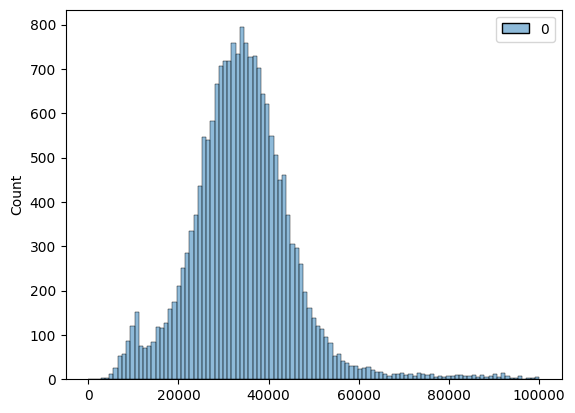

In [23]:
sns.histplot(
    posterpath2filesize.values()
    , binrange=(0, 100_000)
);

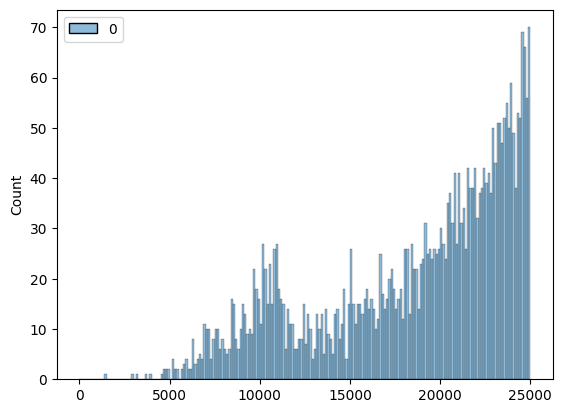

In [30]:
some_filesize = 25_000

sns.histplot(
    posterpath2filesize.values()
    , binrange=(0, some_filesize)
    , bins=200
);

In [3]:
tup2posterpaths = defaultdict(list)

for posterpath, filesize in tqdm(posterpath2filesize.items()):
    
    # if filesize < some_filesize:

        img = Image.open(posterpath)

        tensor = convert_tensor(img)
        
        tup = tuple(tensor[:, :, 0].flatten().tolist())
        
        tup2posterpaths[tup].append(posterpath)

100%|████████████████████████████████████████████████████████████████████████████| 19393/19393 [05:26<00:00, 59.42it/s]


In [ ]:
# sorted(tup2posterpaths.values(), key=len, reverse=True)[:4]

In [31]:
tmp = sorted(tup2posterpaths.values(), key=len, reverse=True)

In [5]:
for posterpath in tmp[0]+tmp[3]: # 0, 3
    img = Image.open(posterpath)
    print(posterpath)
    display(img)
    break

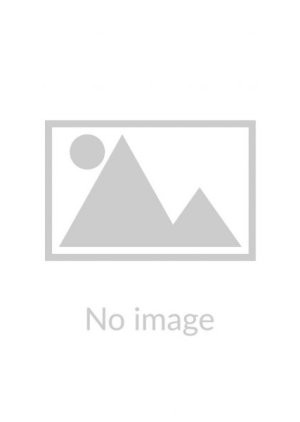

In [8]:
another_dummy_poster_path = "data/posters/no_image/717829-qu-yuan_vLBNq_4c.jpg"
display(Image.open(another_dummy_poster_path))

In [5]:
def tuplify(tensor):
    return {
        tuple(tensor[:, :, 0].flatten().tolist())
        , tuple(tensor[:, :, -1].flatten().tolist())
        , tuple(tensor[:, 0, :].flatten().tolist())
        , tuple(tensor[:, -1, :].flatten().tolist())
    }

def search_poster(posterpath, posterpaths
                  , tuplify=tuplify, convert_tensor=convert_tensor):

    img = Image.open(posterpath)
    tensor = convert_tensor(img)
    tups = tuplify(tensor=tensor)

    d = defaultdict(Counter)

    for posterpath in tqdm(posterpaths):

        img = Image.open(posterpath)
        tensor = convert_tensor(img)

        for tup in tuplify(tensor=tensor):
            if tup in tups:
                d[tup].update([posterpath])

    return d

In [16]:
noimagetup2posterpaths = search_poster(
    another_dummy_poster_path
    , posterpath2filesize
)

100%|███████████████████████████████████████████████████████████████████████████| 19091/19091 [01:11<00:00, 266.11it/s]


In [19]:
for v in noimagetup2posterpaths.values():
    print(len(v))

423
155


In [ ]:
# for posterpath in (
#     set(list(noimagetup2posterpaths.values())[0]) & set(list(noimagetup2posterpaths.values())[1])
# ):
#     print(posterpath)
#     display(Image.open(posterpath))
#     break

In [48]:
# for posterpath in tmp[0]+tmp[3]:
    
#     root, filename = os.path.split(posterpath)
#     new_path = os.path.join(root, "not_released_yet", filename)

#     shutil.move(posterpath, new_path)

In [12]:
# root, filename = os.path.split(another_dummy_poster_path)
# new_path = os.path.join(root, "no_image", filename)

# shutil.move(another_dummy_poster_path, new_path)

'data/posters\\no_image\\717829-qu-yuan_vLBNq_4c.jpg'

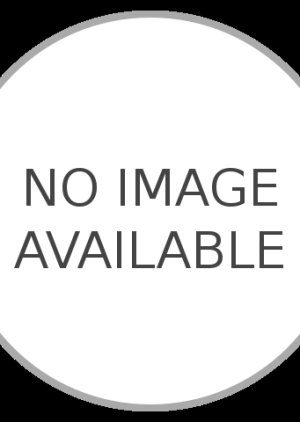

In [3]:
display(Image.open("data/posters/75317-bu-yi-qing-tian_4NNmQ_4c.jpg"))

In [24]:
noimageavailable_poster_path = "data/posters/75317-bu-yi-qing-tian_4NNmQ_4c.jpg"

In [19]:
noimageavailabletup2posterpaths = search_poster(
    noimageavailable_poster_path
    , posterpath2filesize
)

100%|███████████████████████████████████████████████████████████████████████████| 19091/19091 [01:08<00:00, 278.37it/s]


In [25]:
# root, filename = os.path.split(noimageavailable_poster_path)
# new_path = os.path.join(root, "no_image", filename)

# shutil.move(noimageavailable_poster_path, new_path)

'data/posters\\no_image\\75317-bu-yi-qing-tian_4NNmQ_4c.jpg'

In [7]:
dummy_poster_paths = [
    "712191-sea-village-cloud-pension_QqmQ2_4c.jpg"
    , "712075-source-of-the-odour_2WDLV_4c.jpg"
    , "711229-kanojo-no-satsui-ga-koi-wo-shita_q6rx8_4c.jpg"
    , "708913-the-great-shaman-ga-doo-shim-season-2_QL0p2_4c.jpg"
    , "705075-bad-memory-eraser_rJbjE_4c.jpg"
    , "703869-tales-of-horror_dDwWe_4c.jpg"

    , "700441-gyeongseong-creature_1V5ld_4c.jpg"
    , "700087-after-school-war-activities_2bPgd_4c.jpg"
    , "698551-joo-no-hoigaku-shikabane-katsushi_R7BKY_4c.jpg"
    , "694011-novoland-trace-of-the-dragon_BXBbz_4c.jpg"
    , "688925-secret_rJdZN_4c.jpg"
    , "686405-ask-the-stars_BVrOb_4c.jpg"
    , "71407-history4-make-our-days-count-2_jnNQO_4c.jpg"
]

In [ ]:
# dummy_dicts = {}

for filename in dummy_poster_paths:
    dummy_posterpath = f"data/posters/{filename}"
    dummy_dicts[dummy_posterpath] = search_poster(
    dummy_posterpath
    , posterpath2filesize
)

In [49]:
tmp_counter = Counter(
    [
        posterpath
        for d in dummy_dicts.values() for v in d.values() for posterpath in v
        # if os.path.basename(posterpath) not in dummy_poster_paths
    ]
)

In [52]:
len(tmp_counter), tmp_counter.most_common()[-2:]

(50,
 [('data/posters\\743783-europe-outside-your-tent-season-2_EAQgl_4c.jpg', 13),
  ('data/posters\\77733-three-lives-three-worlds-white-twilight-tears_Bzw3b_4c.jpg',
   13)])

data/posters\16115-broker_r4Zz2_4c.jpg


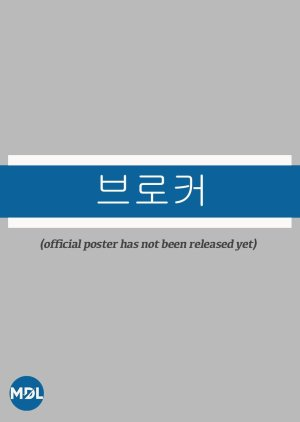

In [54]:
for posterpath in tmp_counter:
    if os.path.basename(posterpath) not in dummy_poster_paths:
        print(posterpath)
        display(Image.open(posterpath))
        break

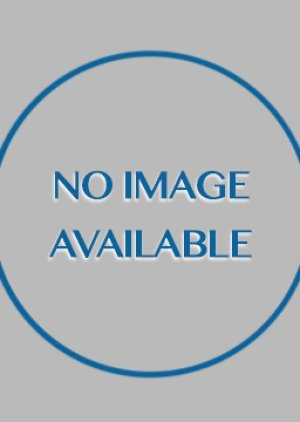

In [56]:

display(Image.open("data/posters/727297-alien-people-part-2_2yDR7_4c.jpg"))

In [57]:
no_image_available_again_poster_path = "data/posters/727297-alien-people-part-2_2yDR7_4c.jpg"

root, filename = os.path.split(no_image_available_again_poster_path)
new_path = os.path.join(root, "no_image", filename)

shutil.move(no_image_available_again_poster_path, new_path)

'data/posters\\no_image\\727297-alien-people-part-2_2yDR7_4c.jpg'

In [60]:
for posterpath in tmp_counter:

    if os.path.basename(posterpath) != os.path.basename(no_image_available_again_poster_path):
    
        root, filename = os.path.split(posterpath)
        new_path = os.path.join(root, "not_released_yet", filename)

        shutil.move(posterpath, new_path)

# Cleaning up num posters

In [11]:
fresh_dummy_poster_paths = [
    "21727_e7QPe_4c.jpg"
    , "21972_X02gX_4c.jpg"
    , "22009_ZZRBk_4c.jpg"
    , "22052_21oDW_4c.jpg"
    , "22690_v4dLe_4c.jpg"
    , "22868_w1P2k_4c.jpg"
    , "22794_6jRzj_4c.jpg"


    , "3833_1BPQy_4c.jpg"
    , "22981_vbZqe_4c.jpg" # not released yet
    , "22980_vekzDc.jpg"
]

In [13]:
# fresh_dummy_dicts = {}

for filename in fresh_dummy_poster_paths:
    dummy_posterpath = f"data/posters/num/{filename}"
    fresh_dummy_dicts[dummy_posterpath] = search_poster(
    dummy_posterpath, posterpath2filesize
    )

100%|███████████████████████████████████████████████████████████████████████████| 12057/12057 [01:05<00:00, 183.12it/s]


In [14]:
tmp_counter = Counter([posterpath 
         for d in fresh_dummy_dicts.values() 
         for v in d.values() for posterpath in v])
tmp_counter.most_common()[-3:]

[('data/posters/num\\22980_vekzDc.jpg', 2),
 ('data/posters/num\\14943_xP373c.jpg', 1),
 ('data/posters/num\\6710_REyyz_4c.jpg', 1)]

In [25]:
for posterpath in tmp_counter:
    if os.path.basename(posterpath) not in fresh_dummy_poster_paths:
        print(posterpath)
        display(Image.open(posterpath))

In [20]:
for posterpath in ["data/posters/num/22979_wA5zbc.jpg"
                   , "data/posters/num/23380_xkjg3c.jpg"
                   , "data/posters/num/22980_vekzDc.jpg"]: #empty
    
        root, filename = os.path.split(posterpath)
        new_path = os.path.join("data/posters", "empty", filename)

        shutil.move(posterpath, new_path)

In [24]:
# for posterpath in ["data/posters/num/14943_xP373c.jpg"
#                    , "data/posters/num/6710_REyyz_4c.jpg"]: # valid

#     display(Image.open(posterpath))

In [23]:
# for posterpath in tmp_counter:
#     if posterpath not in ["data/posters/num/14943_xP373c.jpg"
#                        , "data/posters/num/6710_REyyz_4c.jpg"]: # valid
#         if os.path.exists(posterpath):
            
#             root, filename = os.path.split(posterpath)
#             new_path = os.path.join("data/posters", "not_released_yet", filename)

#             shutil.move(posterpath, new_path)